In [208]:
import json
import io
import os
import re
from collections import Counter
from datetime import datetime
from operator import itemgetter

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from fasttext import FastText
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN, MiniBatchKMeans, AgglomerativeClustering, SpectralClustering
from sklearn.manifold import TSNE
from scipy.spatial.distance import euclidean
from scipy import cluster
from xgboost import XGBClassifier
from scipy.spatial import ConvexHull

In [2]:
ft_ru = FastText.load_model('cc.ru.300.bin')

In [3]:
with io.open(os.path.join(os.getcwd(), 'data', 'habr-favorites.json'), encoding='utf-8') as fp:
    fav_data = json.load(fp)
    
with io.open(os.path.join(os.getcwd(), 'data', 'habr-top-ru.json'), encoding='utf-8') as fp:
    top_data = json.load(fp)    

In [4]:
data = []
link_set = set()

raw_data = fav_data[:]
raw_data.extend(top_data)

for post in raw_data:
    if post['link'] in link_set:
        continue
    link_set.add(post['link'])
    data.append(post)

In [5]:
len(data)

5049

In [6]:
data[0].keys()

dict_keys(['title', 'preview', 'article', 'tags', 'link', 'user'])

In [7]:
df_v = pd.DataFrame(data)

In [8]:
df_v.head()

,title,preview,article,tags,link,user
0,Переписка со спамерами: избранное,"Конец XIV века, неизвестный автор: Комиссия ФА...","Конец XIV века, неизвестный автор: Комиссия ФА...",[Спам и антиспам],https://habr.com/ru/post/580906/,ne555
1,Геоаналитика с помощью Python и открытых данны...,"Геоаналитика с помощью Python: GeoPandas, foli...","Каждый бизнес желает знать, где сидит фазан це...","[Python *, OpenStreetMap *, Геоинформацион...",https://habr.com/ru/post/579838/,ne555
2,Умный дом в квартире,Пробую создать умный дом в квартире на програм...,Пробую создать умный дом в квартире на програм...,"[Разработка на Raspberry Pi *, Умный дом]",https://habr.com/ru/post/577382/,ne555
3,Ventoy. Мультизагрузочная флешка,"Мультизагрузочная флешка, сколько раз она меня...",Так выглядит загрузочный интерфейс Ventoy Утил...,[Софт],https://habr.com/ru/post/575642/,ne555
4,Упавшие с бомбами: аварии и катастрофы самолет...,"Ядерное оружие - это добро. Но только, когда о...",Ядерное оружие - это добро. Но только когда он...,"[Читальный зал, Научно-популярное, Энергия и э...",https://habr.com/ru/post/570344/,ne555


In [9]:
df_vector = []
for idx, row in df_v.iterrows():
    df_vector.append(ft_ru.get_word_vector(row.article))
df_vector = pd.DataFrame(df_vector)

In [10]:
vector2 = TSNE(n_components=2, perplexity=3).fit_transform(df_vector.values)
df_vector = None
ft_ru = None

In [11]:
df_v['tsne_x'] = vector2[:, 0]
df_v['tsne_y'] = vector2[:, 1]

In [12]:
for c in ['x', 'y']:
    minc = df_v[f'tsne_{c}'].min()
    maxc = df_v[f'tsne_{c}'].max()
    df_v[f'{c}'] = (df_v[f'tsne_{c}'] - minc) / (maxc - minc)

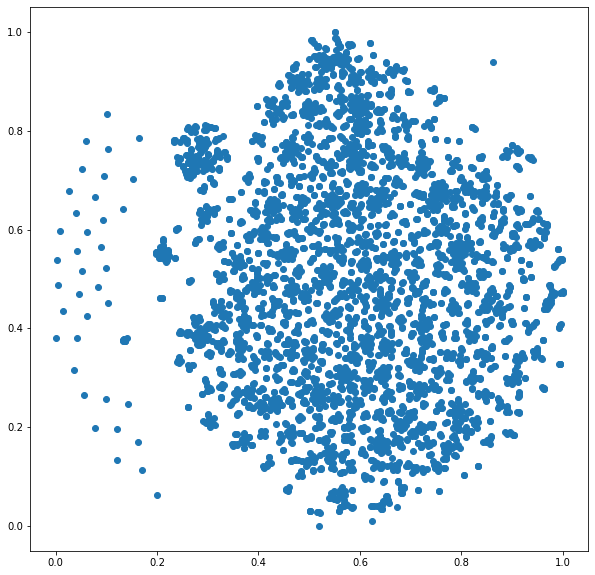

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

ax.scatter(df_v.x, df_v.y)
plt.show()

In [333]:
clustering = AgglomerativeClustering(20).fit(df_v[['x', 'y']].values)

In [334]:
counter = Counter(clustering.labels_)
for cl, cnt in sorted(counter.items(), key=itemgetter(1), reverse=True):
    print(f'{cl}\t{cnt}')

0	463
2	377
6	353
5	342
1	333
8	324
11	311
10	288
12	254
3	251
14	248
17	241
16	216
13	187
7	183
15	167
18	142
19	137
9	131
4	101


In [335]:
df_v['cluster2'] = clustering.labels_

In [336]:
clusters = df_v.cluster2.unique()
n_clusters = len(clusters)

In [337]:
colors = sns.color_palette('husl', n_clusters)

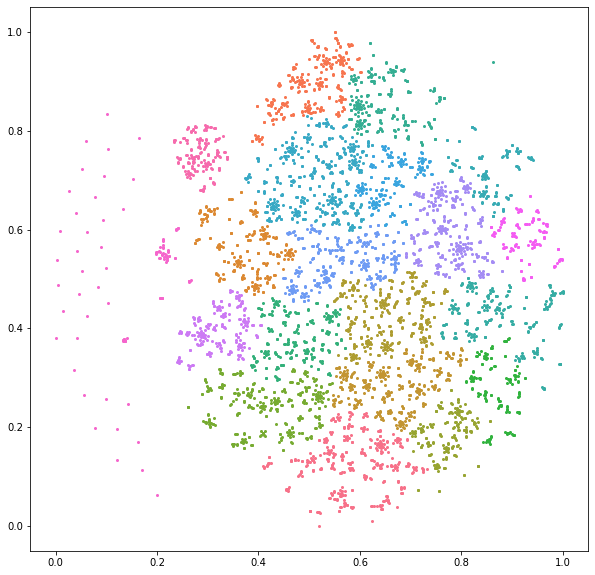

In [338]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

for i, cl in enumerate(clusters):
    idx = df_v[df_v['cluster2'] == cl].index
    ax.scatter(df_v.loc[idx, 'x'], df_v.loc[idx, 'y'], color=colors[i], label=f'{cl}', s=4)

plt.show()

In [339]:
stemmer = SnowballStemmer('russian')
stop_words = stopwords.words('russian')
stop_words.extend(stopwords.words('english'))
stop_words.extend([
    'это', 'нею', 
    'который', 'которая', 'которые', 'которых', 'которое', 'которого', 'которому', 
    'данный', 'данная', 'данное', 'данные', 'данного', 'данному',
    'такой', 'такая', 'такие', 'таких', 'такое', 'такого', 'такому',
    'вы', 'ваш', 'вашего', 'вашему',
])
stop_words = set(stop_words)

symbol_replacer = re.compile(r'[^а-яёa-z\s]+')
space_replacer = re.compile(r'\s+')


def normalize_text(text):
    text = text.lower()
    text = space_replacer.sub(' ', symbol_replacer.sub(' ', text))
    
    words = []
    for word in text.split(' '):
        if word in stop_words:
            continue
        norm_word = stemmer.stem(word)
        words.append(norm_word)
    
    return words


df_v['article_words'] = df_v.article.apply(lambda x: normalize_text(x))
stop_words = None
stemmer = None

In [340]:
df_v['article_norm'] = df_v.article_words.apply(lambda x: ' '.join(x))

In [341]:
df_v['article_words_len'] = df_v.article_words.apply(lambda x: len(x))

In [342]:
df_v.article_words.head()

0    [конец, xiv, век, неизвестн, автор, комисс, фа...
1    [кажд, бизнес, жела, знат, сид, фаза, целев, а...
2    [проб, созда, умн, дом, квартир, программн, пл...
3    [выгляд, загрузочн, интерфейс, ventoy, утил, с...
4    [ядерн, оруж, добр, он, мирн, леж, склад, сво,...
Name: article_words, dtype: object

In [343]:
df_v.article_words_len.describe()

count     5049.000000
mean      1326.455734
std       1294.833442
min          1.000000
25%        586.000000
50%       1019.000000
75%       1649.000000
max      28293.000000
Name: article_words_len, dtype: float64

<AxesSubplot:>

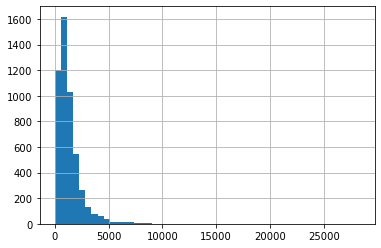

In [344]:
df_v.article_words_len.hist(bins=50)

In [345]:
vectorizer = TfidfVectorizer()
vectorizer.fit(df_v.article_norm.values)

TfidfVectorizer()

In [346]:
article_vectors = vectorizer.transform(df_v['article_norm'].values)
df_av = pd.DataFrame(article_vectors.toarray())
article_vectors = None

In [347]:
clu_tags = {}
for clu in df_v.cluster2.unique():
    idx = df_v[df_v['cluster2'] == clu].index
    clu_tags[clu] = df_av.loc[idx].sum(axis=0).sort_values(ascending=False).head(100).index

In [348]:
tag_set = set()
for clu, tag_idx in clu_tags.items():
    tag_set.update(tag_idx)
tag_set = list(tag_set)

In [349]:
df_av[tag_set].shape

(5049, 840)

In [350]:
df_v['cluster'] = df_v.cluster2

In [351]:
xg = XGBClassifier(use_label_encoder=False)
xg.fit(df_av[tag_set], df_v['cluster'])

[21:47:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [352]:
df_v['forecast'] = xg.predict(df_av[tag_set])

In [353]:
df_v[df_v.cluster != df_v.forecast].shape[0] / df_v.shape[0]

0.0

In [354]:
full_idx = np.array(df_v.index[:])
np.random.shuffle(full_idx)
batches = np.array_split(full_idx, 4)

In [355]:
for i, batch in enumerate(batches):
    print(f'Forecast {i}', datetime.now())
    train_idx = []
    for j in range(len(batches)):
        if j == i:
            continue 
        train_idx.extend(batches[j])

    X_train = df_av.loc[train_idx, tag_set]
    Y_train = df_v.loc[train_idx, 'cluster']

    xg = XGBClassifier(use_label_encoder=False)
    xg.fit(X_train, Y_train)

    X_test = df_av.loc[batch, tag_set]
    df_v.loc[batch, 'forecast2'] = xg.predict(X_test)

Forecast 0 2021-10-14 21:48:20.799401
[21:48:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Forecast 1 2021-10-14 21:48:44.992690
[21:48:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Forecast 2 2021-10-14 21:49:09.216895
[21:49:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_met

In [356]:
df_v[df_v.cluster != df_v.forecast2].shape[0] / df_v.shape[0]

0.5490196078431373

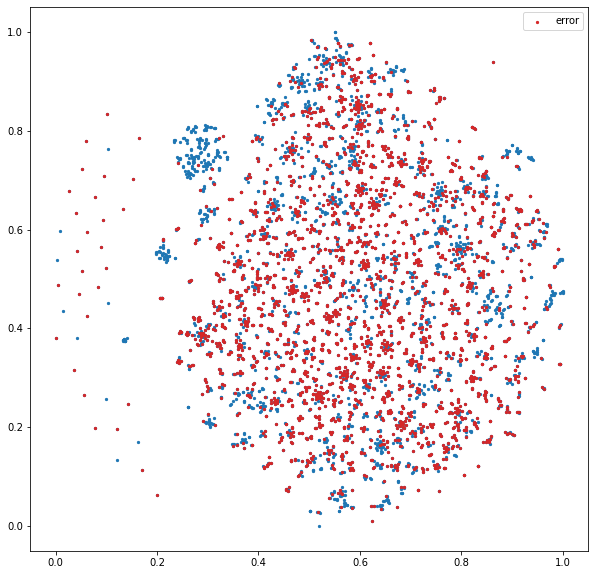

In [357]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

ax.scatter(df_v.x, df_v.y, s=5)

idx = df_v[df_v.cluster != df_v.forecast2].index
ax.scatter(df_v.loc[idx, 'x'], df_v.loc[idx, 'y'], color='tab:red', label=f'error', s=5)

ax.legend()
plt.show()

In [358]:
df_voc = pd.DataFrame(vectorizer.vocabulary_, index=['voc']).T.reset_index().set_index('voc')
df_voc.columns = ['voc']

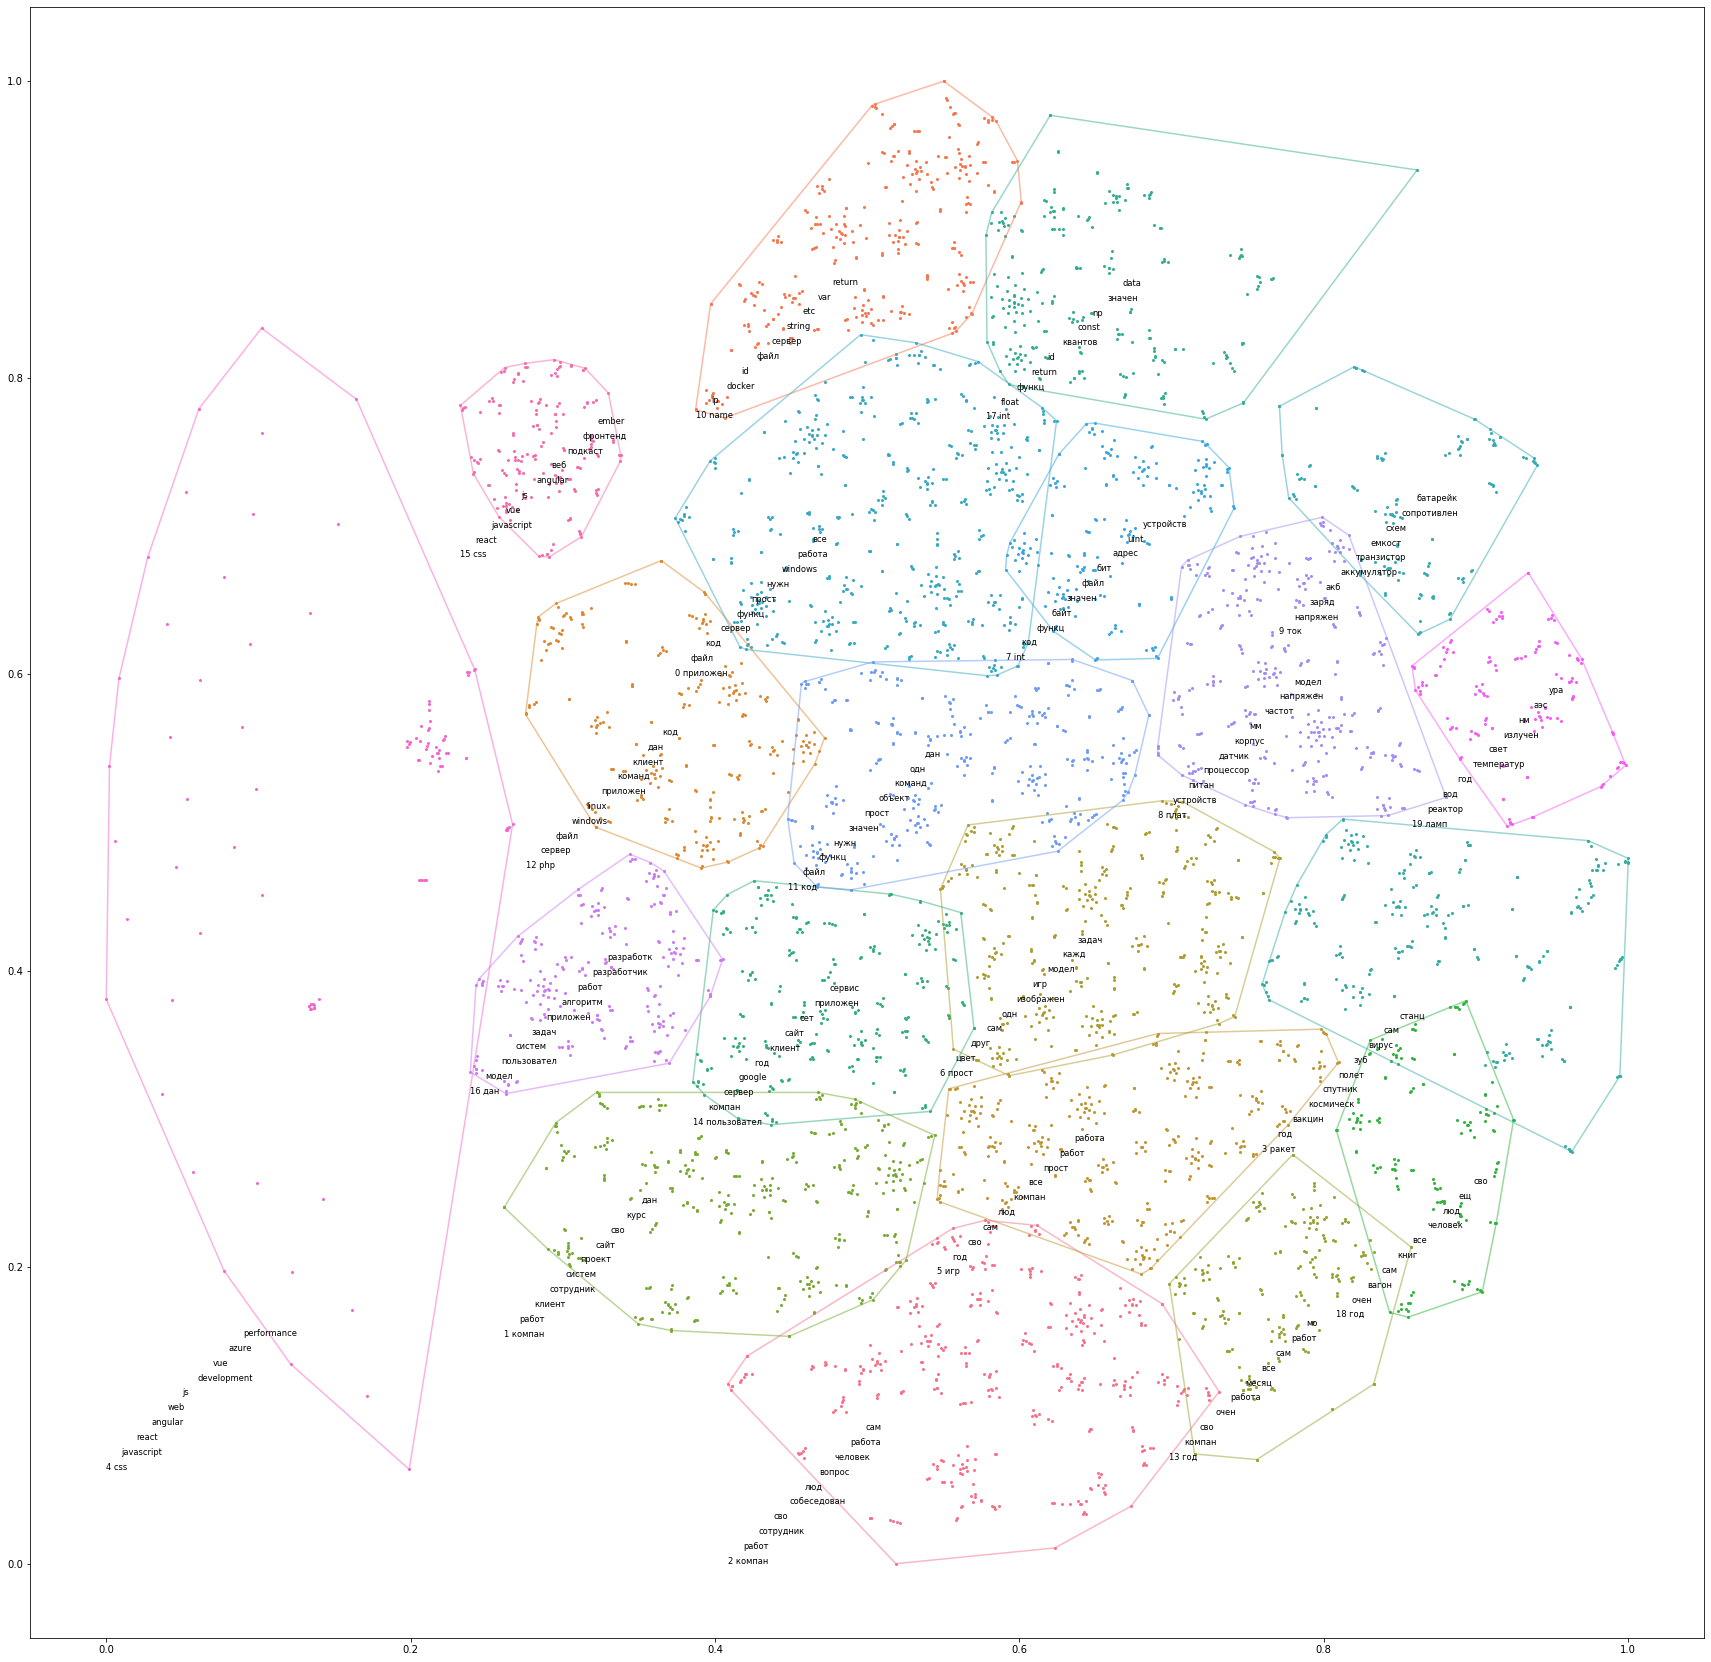

In [359]:
fig, ax = plt.subplots()
fig.set_size_inches(30, 30)

for i, cl in enumerate(clusters):
    idx = df_v[df_v['cluster2'] == cl].index
    df_plt = df_v.loc[idx]
    ax.scatter(df_v.loc[idx, 'x'], df_v.loc[idx, 'y'], color=colors[i], label=f'{cl}', s=4)
    hull = ConvexHull(df_v.loc[idx, ['x', 'y']])
    vertices = np.concatenate([hull.vertices, [hull.vertices[0]]])
    
    ax.plot(df_plt.iloc[vertices]['x'], df_plt.iloc[vertices]['y'], color=colors[i], alpha=.5)
    
    words = df_voc.loc[clu_tags[cl]].head(10)['voc'].values
    text_xy = df_v.loc[idx, ['x', 'y']].min()
    #text_xy = df_plt.iloc[vertices[0]][['x', 'y']]
    
    for i, word in enumerate(words):
        if i == 0:
            word = f'{cl} ' + word
        ax.text(text_xy['x']+0.01*i, text_xy['y']+0.01*i, word, size='small')

plt.show()

In [360]:
df_v[df_v.cluster==9]

,title,preview,article,tags,link,user,tsne_x,tsne_y,x,y,cluster2,article_words,article_norm,article_words_len,cluster,forecast,forecast2
20,Вакуумное напыление «на коленке»,Вакуумное напыление (англ. physical vapor depo...,Вакуумное напыление (англ. physical vapor depo...,"[Блог компании RUVDS.com, Физика, DIY или Сдел...",https://habr.com/ru/company/ruvds/blog/580218/,ntsaplin,59.558208,28.619404,0.871698,0.651459,9,"[вакуумн, напылен, англ, physical, vapor, depo...",вакуумн напылен англ physical vapor deposition...,1773,9,9,9.0
48,Нужно ли заряжать аккумулятор на новом автомоб...,"Или новый, только с конвейера аккумулятор, не ...","Или новый, только с конвейера аккумулятор, не ...","[Блог компании RUVDS.com, Научно-популярное, Э...",https://habr.com/ru/company/ruvds/blog/563314/,ntsaplin,63.294361,47.449860,0.889109,0.752693,9,"[нов, конвейер, аккумулятор, успевш, запыл, ск...",нов конвейер аккумулятор успевш запыл склад ст...,1242,9,9,9.0
61,Перемешивается ли электролит в аккумуляторе пр...,"Привет, Хабр! Серная кислота почти вдвое тяжел...","Привет, Хабр! Серная кислота почти вдвое тяжел...","[Блог компании RUVDS.com, Научно-популярное, Э...",https://habr.com/ru/company/ruvds/blog/562426/,ntsaplin,67.736275,49.301998,0.909809,0.762650,9,"[привет, хабр, серн, кислот, вдво, тяжел, вод,...",привет хабр серн кислот вдво тяжел вод е водн ...,1182,9,9,9.0
75,Мото AGM аккумулятор: ввод в эксплуатацию,"Привет, Хабр! Сегодня мы введём в эксплуатацию...","Привет, Хабр! Сегодня мы введём в эксплуатацию...","[Блог компании RUVDS.com, Научно-популярное, Э...",https://habr.com/ru/company/ruvds/blog/559470/,ntsaplin,68.334618,47.787689,0.912597,0.754509,9,"[привет, хабр, сегодн, введ, эксплуатац, сухоз...",привет хабр сегодн введ эксплуатац сухозаряжен...,1068,9,9,9.0
86,Защита от гнева богов. Устройства защиты от им...,Продолжаем тему электроликбеза про устройства ...,Продолжаем тему электроликбеза про устройства ...,"[Блог компании RUVDS.com, Научно-популярное, Э...",https://habr.com/ru/company/ruvds/blog/559878/,ntsaplin,54.253277,33.074417,0.846976,0.675410,9,"[продолжа, тем, электроликбез, устройств, защи...",продолжа тем электроликбез устройств защит пос...,2719,9,9,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4803,Пушка Гаусса,Хомяки приветствуют обитателей третьей от солн...,Хомяки приветствуют обитателей третьей от солн...,"[Научно-популярное, Физика, DIY или Сделай сам...",https://habr.com/ru/post/488540/,NaN,52.397556,45.977341,0.838328,0.744777,9,"[хомяк, приветств, обитател, трет, солнц, план...",хомяк приветств обитател трет солнц планет сег...,1152,9,9,8.0
4934,Хождение по мукам или долгая история одной поп...,На дворе стоял 2019 год. В нашу лабораторию по...,На дворе стоял 2019 год. В нашу лабораторию по...,"[Системное администрирование *, Восстановлен...",https://habr.com/ru/post/475146/,NaN,49.474190,33.533298,0.824704,0.677877,9,"[двор, стоя, год, наш, лаборатор, поступ, обыч...",двор стоя год наш лаборатор поступ обычн наш в...,755,9,9,7.0
4945,"Самодельный электромобиль — всё не так, как ду...",Всем привет. Учась в университете я собрал мал...,Всем привет. Учась в университете я собрал мал...,"[Анализ и проектирование систем *, Энергия и...",https://habr.com/ru/post/473708/,NaN,54.397408,40.947453,0.847647,0.717736,9,"[всем, привет, уч, университет, собра, маленьк...",всем привет уч университет собра маленьк элект...,824,9,9,8.0
4970,"Что показывает вольтметр, или математика розетки",О чем эта статья Сегодня я ненадолго отступлю ...,О чем эта статья Сегодня я ненадолго отступлю ...,"[Разработка для интернета вещей *, Производс...",https://habr.com/ru/post/470612/,NaN,58.955555,33.007828,0.868889,0.675052,9,"[эт, стат, сегодн, ненадолг, отступл, сво, обы...",эт стат сегодн ненадолг отступл сво обычн тем ...,1101,9,9,9.0
